In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728066883.057954      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1004 18:34:43.066214214      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1004 18:34:43.066229321      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1004 18:34:43.066233208      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1004 18:34:43.066236031      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1004 18:34:43.066238706      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728066991.106994      13 service.cc:145] XLA service 0x5aa456059ae0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728066991.107055      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728066991.107059      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728066991.107062      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728066991.107065      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728066991.107068      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728066991.107070      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728066991.107073      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728066991.107075      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

I0000 00:00:1728066995.938172      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=16,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-ResNet50v2_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-04 18:38:54.925880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728067136.004023     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8f3c315d412faaf3:0:0), session_name()


  2/445 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.6250 - loss: 0.6644   

I0000 00:00:1728067148.209742     824 tpu_compile_op_common.cc:245] Compilation of 8f3c315d412faaf3:0:0 with session name  took 12.205656702s and succeeded
I0000 00:00:1728067148.220871     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8f3c315d412faaf3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6986509220301993296", property.function_library_fingerprint = 3996304426032154943, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728067148.220915     824 tpu_compilation_cache_interface.cc:541] After adding entry for key 

444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5764 - loss: 0.6706

2024-10-04 18:40:04.353653: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728067205.019210     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d643a9d40c87ba60:0:0), session_name()
I0000 00:00:1728067215.024500     824 tpu_compile_op_common.cc:245] Compilation of d643a9d40c87ba60:0:0 with session name  took 10.005197182s and succeeded
I0000 00:00:1728067215.036606     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d643a9d40c87ba60:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12574206435298307988", property.function_library_fingerprint = 5806408455620418227, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

445/445 ━━━━━━━━━━━━━━━━━━━━ 90s 164ms/step - accuracy: 0.5766 - loss: 0.6705 - val_accuracy: 0.5516 - val_loss: 0.6713
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.6222 - loss: 0.6211 - val_accuracy: 0.6323 - val_loss: 0.6957
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.6452 - loss: 0.6173 - val_accuracy: 0.6323 - val_loss: 0.6618
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.6474 - loss: 0.6232 - val_accuracy: 0.6188 - val_loss: 0.7008
Epoch 5/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.6493 - loss: 0.6126 - val_accuracy: 0.5874 - val_loss: 0.6500
Epoch 6/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.6543 - loss: 0.5971 - val_accuracy: 0.6054 - val_loss: 0.6436
Epoch 7/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.6956 - loss: 0.5868 - val_accuracy: 0.6054 - val_loss: 0.6411
Epoch 8/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6893 - loss: 0.5733 - val

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728070369.174142     775 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d891af7da7034132:0:0), session_name()


 2/56 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.6875 - loss: 0.7518

I0000 00:00:1728070378.004460     775 tpu_compile_op_common.cc:245] Compilation of d891af7da7034132:0:0 with session name  took 8.830207585s and succeeded
I0000 00:00:1728070378.014517     775 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d891af7da7034132:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12574206435298307988", property.function_library_fingerprint = 5806408455620418227, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728070378.014550     775 tpu_compilation_cache_interface.cc:541] After adding entry for key 

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7430 - loss: 0.6660

I0000 00:00:1728070384.004624     748 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3936ff428a6e36ad:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.7430 - loss: 0.6665


I0000 00:00:1728070392.801507     748 tpu_compile_op_common.cc:245] Compilation of 3936ff428a6e36ad:0:0 with session name  took 8.796815723s and succeeded
I0000 00:00:1728070392.812302     748 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3936ff428a6e36ad:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12574206435298307988", property.function_library_fingerprint = 5806408455620418227, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728070392.812332     748 tpu_compilation_cache_interface.cc:541] After adding entry for key 

Test accuracy: 74.44%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-04 19:34:39.807815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728070480.154614     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(100be6696601f7c2:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:47 12s/step

I0000 00:00:1728070488.679747     822 tpu_compile_op_common.cc:245] Compilation of 100be6696601f7c2:0:0 with session name  took 8.525085087s and succeeded
I0000 00:00:1728070488.690864     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(100be6696601f7c2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7663874067111596343", property.function_library_fingerprint = 16800881121359305549, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728070488.690903     822 tpu_compilation_cache_interface.cc:541] After adding entry for key 100be669660

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step

I0000 00:00:1728070509.397515     760 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bc03005d030ad87e:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 541ms/step


I0000 00:00:1728070518.406079     760 tpu_compile_op_common.cc:245] Compilation of bc03005d030ad87e:0:0 with session name  took 9.008513976s and succeeded
I0000 00:00:1728070518.416284     760 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bc03005d030ad87e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17641948324948776806", property.function_library_fingerprint = 10492483842395408767, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728070518.416331     760 tpu_compilation_cache_interface.cc:541] After adding entry for 

Accuracy: 0.7573033707865169
Precision: 0.7584791071299464
Recall: 0.7572651903360564
F1 Score: 0.7570085661306041
Number of Epochs: 90
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step


<Figure size 1600x1600 with 0 Axes>

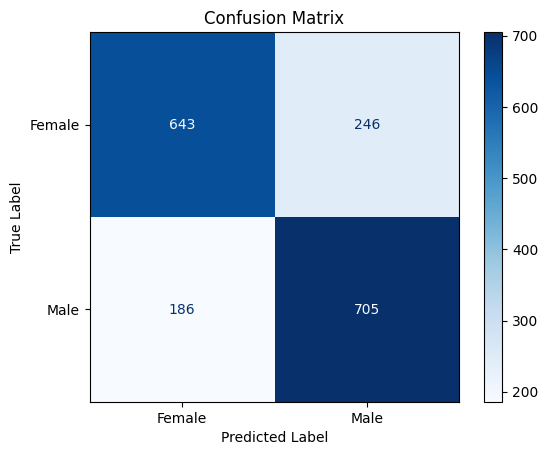

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

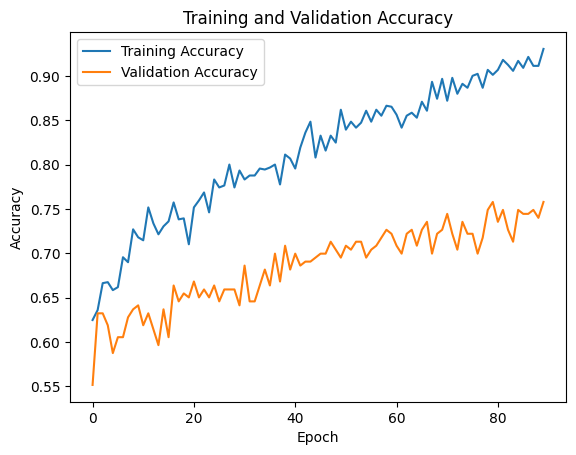

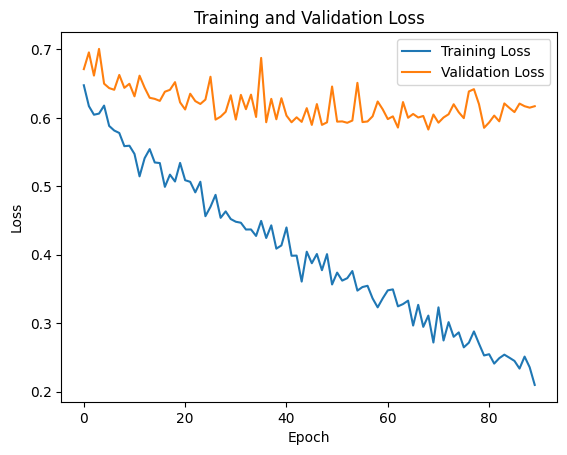

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()